In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ppr.robot import Robot_2P3R,Robot_3R
from ppr.path import TrajectoryPt, TolerancedNumber
from ppr.geometry import Rectangle
from ppr.path import cart_to_joint
from ppr.path import get_shortest_path

In [21]:
# ROBOT
robot1 = Robot_2P3R([1, 1, 2, 1.2, 1])
robot1.set_joint_limits([(0.5, 1.0), (2.0, 3.0)])
robot1.ik_samples = [3, 5]

# PATH
dx    = TolerancedNumber(0.5, 0.3, 0.8, samples=4)
dy    = np.linspace(2, 2.5, 5)
angle = TolerancedNumber(0.0, -np.pi, 0, samples=10)
path1 = [TrajectoryPt([dx, yi, angle]) for yi in dy]

# COLLISION SCENE
sc1 = [Rectangle(1, 1, 1, 1.5, 0),
       Rectangle(3, 1, 1, 2.2, 0),
       Rectangle(0, 3.2, 4, 0.5, 0),
       Rectangle(0, 1, 0.2, 3.2, 0),
       Rectangle(0.2, 1, 0.8, 0.5, 0)]

In [22]:
path_js = cart_to_joint(robot1, path1, check_collision=True, scene=sc1)
print([len(qp) for qp in path_js])

[19, 27, 23, 41, 71]


converting type of Q
[ 3  4 13 40 70]
True
0.7173054218292236


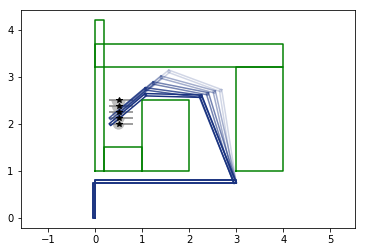

In [23]:
sol = get_shortest_path(path_js)
print(sol['success'])
print(sol['length'])

fig2, ax2 = plt.subplots()
ax2.axis('equal')
#robot1.plot_path_kinematics(ax2, path_js[2])
robot1.plot_path(ax2, sol['path'])
for r in sc1: r.plot(ax2, 'g')
for tp in path1: tp.plot(ax2)
plt.show()

In [30]:
sol['path']

[array([ 0.75      ,  3.        ,  1.94679105,  1.1677134 , -5.55796528]),
 array([ 0.75      ,  3.        ,  1.95244253,  1.05400395, -5.4499073 ]),
 array([ 0.75      ,  3.        ,  1.87018967,  1.0770514 , -5.39070225]),
 array([ 0.75      ,  3.        ,  1.79435527,  1.07941508, -5.31723118]),
 array([ 0.75      ,  3.        ,  1.72573841,  1.06117582, -5.23037529])]

In [25]:
def get_new_bounds(l, u, m, red=4):
    """ create new interval smaller than the old one (l, u)
    reduced in length by a factor red.
    m is the value around wich the new interval should be centered
    the new interval may not go outside the old bounds
    """
    delta = abs(u - l) / red
    l_new = max(m - delta, l)
    u_new = min(m + delta, u)
    return l_new, u_new

def resample_trajectory_point(tp, pfk, *arg, **kwarg):
    """ create a new trajectory point with smaller bounds,
    but same sample number
    use the value from the forward kinematics pfk as the center
    of the new interval
    """
    p_new = []
    for i, val in enumerate(tp.p):
        if tp.hasTolerance[i]:
            # check for rounding errors on pfk
            if pfk[i] < val.l:
                pfk[i] = val.l
            if pfk[i] > val.u:
                pfk[i] = val.u
            l, u = get_new_bounds(val.l, val.u, pfk[i], *arg, **kwarg)
            val_new = TolerancedNumber(pfk[i], l, u, samples=val.s)
        else:
            val_new = val
        p_new.append(val_new)
    return TrajectoryPt(p_new)

def resample_path(path, q_sol, robot, *arg, **kwarg):
    poses = [robot.fk(q) for q in q_sol]
    path_new = []
    for i, tp in enumerate(path1):
        path_new.append(resample_trajectory_point(tp, poses[i], *arg, **kwarg))
    
    return path_new

In [31]:
path2 = resample_path(path1, sol['path'], robot1, red=5)
robot1.set_joint_limits([(0.65, 0.85), (2.9, 3.0)])

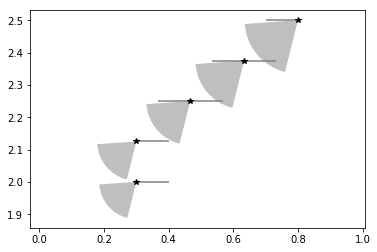

In [32]:
fig1, ax1 = plt.subplots()
ax1.axis('equal')
for tp in path2: tp.plot(ax1)
plt.show()

In [33]:
path_js_new = cart_to_joint(robot1, path2, check_collision=True, scene=sc1)
print([len(qp) for qp in path_js])

sol_new = get_shortest_path(path_js_new)
print(sol_new['success'])
print(sol_new['length'])

[19, 27, 23, 41, 71]
converting type of Q
[ 26  96 121 140  68]
True
0.5691347122192383


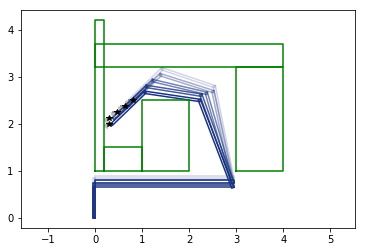

[array([ 0.64999998,  2.95000005,  1.93379259,  1.06145811, -5.36889839]),
 array([ 0.75      ,  2.95000005,  1.91711533,  1.06682384, -5.35758686]),
 array([ 0.75      ,  2.95000005,  1.85599756,  1.05399001, -5.28363562]),
 array([ 0.75      ,  2.95000005,  1.78270817,  1.05034828, -5.20670414]),
 array([ 0.85000002,  2.95000005,  1.76893413,  1.04711497, -5.18969679])]

In [36]:
fig3, ax3 = plt.subplots()
ax3.axis('equal')
robot1.plot_path(ax3, sol_new['path'])
for r in sc1: r.plot(ax3, 'g')
for tp in path2: tp.plot(ax3)
plt.show()

sol_new['path']

In [10]:
current_path = path1
costs = []
for i in range(10):
    Q = cart_to_joint(robot1, current_path, check_collision=True, scene=sc1)
    sol = get_shortest_path(Q)
    if sol['success']:
        current_path = resample_path(current_path, sol['path'], robot1, red=10)
        costs.append(sol['length'])
    else:
        print("No solution in graph found")
print(costs)

converting type of Q
[24 16 12 10  8  8  4  4  4  4]
converting type of Q
[84  2 42 80  0 14 24 22 20 20]
converting type of Q
[68 48 48 48  8  8  6  4  2  2]
converting type of Q
[90 90 90 90 90 86 74 66 58 52]
converting type of Q
[90 90 90 88 90 84 70 64 58 52]
converting type of Q
[28 28 28 28 28 26 22 20 16 14]
converting type of Q
[90 90 90 84 90 80 66 60 56 52]
converting type of Q
[90 90 90 78 88 76 64 60 54 52]
converting type of Q
[28 28 28 24 28 24 20 16 16 14]
converting type of Q
[90 70 70 60 68 58 48 44 40 38]
[1.0956737995147705, 0.9967334270477295, 0.9503164291381836, 0.9498753547668457, 0.9497448205947876, 0.9496617317199707, 0.9495822191238403, 0.9495096802711487, 0.9459354877471924, 0.9458138942718506]


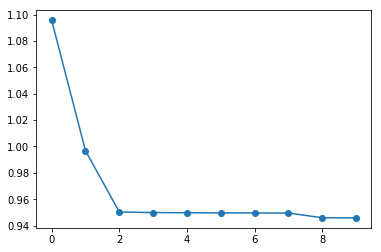

In [12]:
plt.plot(costs, 'o-')
plt.show()